In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import h5py
import time
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [0]:
with h5py.File(os.path.join(root_path, 'mitdb', 'train_ecg.hdf5'), 'r') as hdf:
    x = hdf['x_train'][:]
    y = hdf['y_train'][:]

In [0]:
x_list = [list() for i in range(5)]
y_list = ['N', 'L', 'R', 'A', 'V']

In [5]:
for i in range(len(x_list)):
    idx = np.where(y == i)
    x_list[i] = x[idx]
    print(x_list[i].shape)

(3000, 1, 128)
(3000, 1, 128)
(3000, 1, 128)
(1245, 1, 128)
(3000, 1, 128)


In [0]:
class EcgConv2(nn.Module):
    def __init__(self):
        super(EcgConv2, self).__init__()        
        self.conv1 = nn.Conv1d(1, 16, 7, padding=3)  # 128 x 16
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(2)  # 64 x 16
        self.conv2 = nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(2)  # 32 x 16
        self.linear3 = nn.Linear(32 * 16, 128)
        self.relu3 = nn.LeakyReLU()
        self.linear4 = nn.Linear(128, 5)
        self.softmax4 = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        return x.data.numpy().squeeze()

In [0]:
conv2 = EcgConv2()
conv2.load_state_dict(torch.load(os.path.join(root_path, 'model', 'conv2_1_10.pth')))
conv2.eval()

random.seed(28)

In [0]:
def pick_for_each_class(x_list):
    return_list = []
    for i in range(len(x_list)):
        return_list.append(random.choice(x_list[i]))
    return return_list

# Original Signals

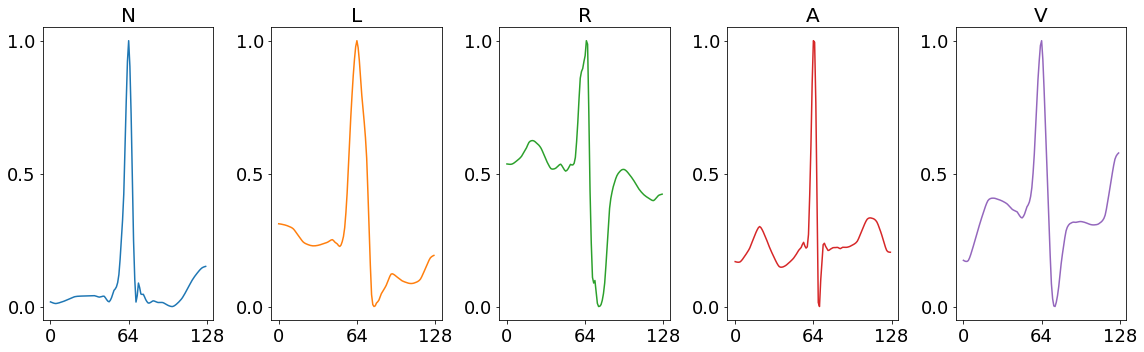

In [9]:
random_signals = pick_for_each_class(x_list)
fig, ax = plt.subplots(1, 5, figsize=(16, 5))
for i in range(len(random_signals)):
    ax[i].set_title(y_list[i], size=20)
    ax[i].tick_params(labelsize=18)
    r = random_signals[i].squeeze() # normalize
    r = (r - min(r)) / (max(r) - min(r))
    ax[i].plot(r, color='C'+str(i))
    ax[i].set_xticks([0, 64, 128])
    ax[i].set_yticks([0, 0.5, 1.0])
fig.tight_layout()
fig.savefig(os.path.join(root_path, 'img', 'visual_invert_before.pdf'), bbox_inches="tight")

# Activations after 2 Conv. Layers

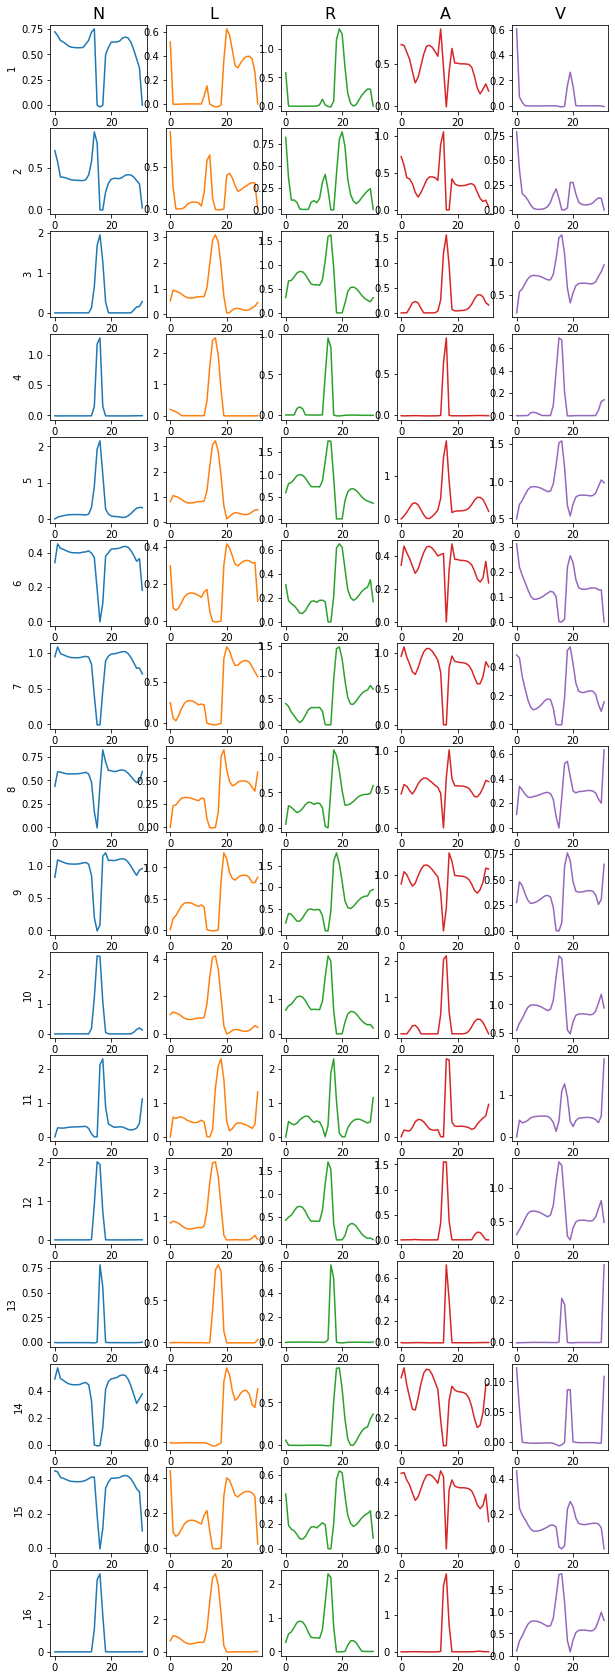

In [10]:
fig, ax = plt.subplots(16, 5, figsize=(10, 30))
for i in range(len(x_list)):
    output = conv2(torch.tensor(np.expand_dims(random_signals[i], axis=0), dtype=torch.float))
    for j in range(len(output)):
        if j == 0:
            ax[j][i].set_title(y_list[i], size=16)
        if i == 0:
            ax[j][i].set_ylabel(str(j+1))
        ax[j][i].plot(output[j], color='C'+str(i))

## The Most Similar One (Filter 14)

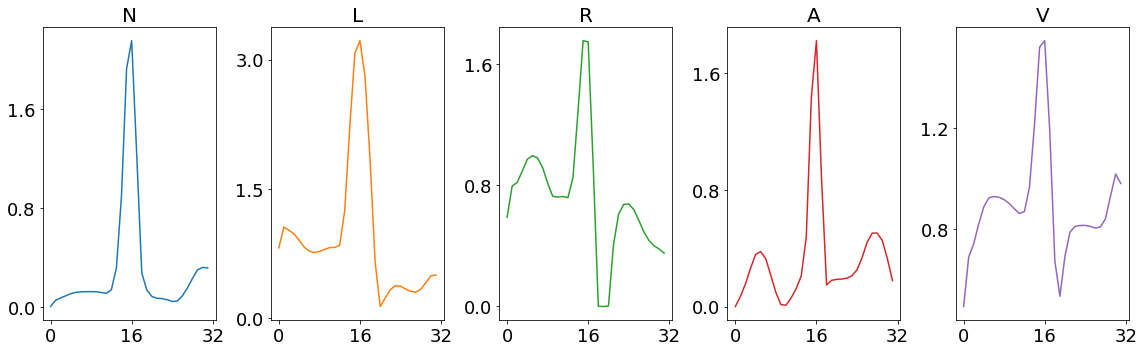

In [11]:
fig, ax = plt.subplots(1, 5, figsize=(16, 5))
for i in range(len(x_list)):
    output = conv2(torch.tensor(np.expand_dims(random_signals[i], axis=0), dtype=torch.float))
    ax[i].set_title(y_list[i], size=20)
    ax[i].plot(output[4], color='C'+str(i)) # filter 14
    ax[i].tick_params(labelsize=18)
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(3))
    ax[i].set_xticks([0, 16, 32])
fig.tight_layout()
fig.savefig(os.path.join(root_path, 'img', 'visual_invert_after.pdf'), bbox_inches="tight")